# Dat550 Project

In [256]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D, Embedding, TextVectorization

## Data Loading Functions

In [257]:
# Load articles
def load_articles(filepath):
    articles = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            text = data["title"] + " " + data["content"]
            articles.append({
                "id": data["id"],
                "text": text
            })
    return articles

# Load labels
def load_labels(filepath):
    labels = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            labels.append({
                "id": str(data["id"]).zfill(7),  # Zero-pad to match article IDs
                "label": 1 if data["hyperpartisan"] else 0
            })
    return labels

## File paths

In [258]:
train_articles_path = "preprocessing/data/articles-training-byarticle.jsonl"
train_labels_path = "preprocessing/data/ground-truth-training-byarticle.jsonl"
test_articles_path  = "preprocessing/data/articles-test-byarticle.jsonl"
test_labels_path    = "preprocessing/data/ground-truth-test-byarticle.jsonl"

## Load and Merge Training Data

In [ ]:
train_articles_df = pd.DataFrame(load_articles(train_articles_path))
train_labels_df   = pd.DataFrame(load_labels(train_labels_path))
train_articles_df["id"] = train_articles_df["id"].astype(str)
# Merge training data on 'id'
train_df = pd.merge(train_articles_df, train_labels_df, on="id")
# For training, we only need the text and the label

# Add publication data and such for more feature?

texts_train = train_df["text"].tolist()
labels_train = train_df["label"].values

print("Training data samples:", len(texts_train))

Training data samples: 645


## Load and Merge Test Data

In [ ]:
test_articles_df = pd.DataFrame(load_articles(test_articles_path))
test_labels_df   = pd.DataFrame(load_labels(test_labels_path))
test_articles_df["id"] = test_articles_df["id"].astype(str)
# Merge test data on 'id'
test_df = pd.merge(test_articles_df, test_labels_df, on="id")
texts_test = test_df["text"].tolist()
labels_test = test_df["label"].values

print("Test data samples:", len(texts_test))

Test data samples: 628


## Preprocessing the Text with TextVectorization

In [ ]:
max_tokens = 10000          # Maximum vocabulary size
max_sequence_length = 200   # Maximum sequence length (adjust as needed)

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(texts_train)

# Vectorize the texts. The output is a tensor of shape (num_samples, max_sequence_length)
X_train = vectorize_layer(texts_train)
X_test  = vectorize_layer(texts_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (645, 200)
X_test shape: (628, 200)


## Build the Convolutional Neural Network (CNN) Model 

In [ ]:
model = Sequential([
    Input(shape=(max_sequence_length,)),
    # Embedding layer maps integer sequences to dense vectors.
    Embedding(input_dim=max_tokens, output_dim=128),
    Conv1D(filters=100, kernel_size=3, activation='relu'),
    GlobalMaxPool1D(),
    # Fully connect the network
    Dense(units=64, activation='relu'),
    # Output layer
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 198, 100)       │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_27         │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,029 (5.05 MB)

 Trainable params: 1,325,029 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [263]:
history = model.fit(X_train, labels_train, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5993 - loss: 0.6778 - val_accuracy: 0.7209 - val_loss: 0.6126
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6316 - loss: 0.6159 - val_accuracy: 0.7209 - val_loss: 0.6046
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7118 - loss: 0.5264 - val_accuracy: 0.6899 - val_loss: 0.6083
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9585 - loss: 0.3130 - val_accuracy: 0.7597 - val_loss: 0.5273
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0807 - val_accuracy: 0.7597 - val_loss: 0.5145
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.7364 - val_loss: 0.5300
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7364 - val_loss: 0.5287
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.7364 - val_loss

## Evaluate & Predict on Test Data

Final Evaluation - Loss: 0.6007, Accuracy: 0.6815
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


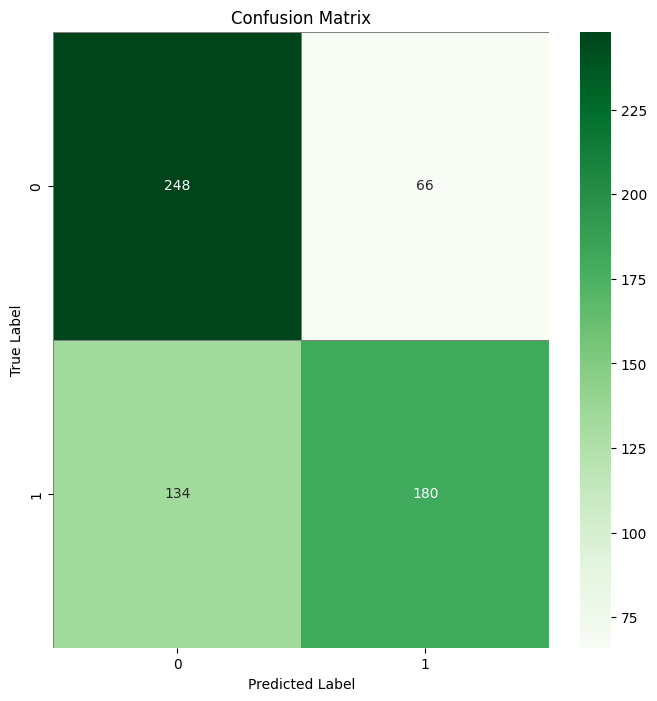

In [264]:
# Evaluate the model on test data and print loss and accuracy:
loss_eval, acc_eval = model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions = model.predict(X_test)
pred_y = (predictions >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()